# [실습]  온라인 소비자 군집분석
* 타깃마케팅을 위한 K-평균 군집화

In [131]:
# 영국 온라인 소매 플랫폼: 2010년 12월 1일 ~ 2011년 12월 9일
# 데이터 갯수: 541,909개

In [132]:
print("https://archive.ics.uci.edu/ml/index.php")

https://archive.ics.uci.edu/ml/index.php


In [133]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

### 1) 데이터 수집

In [134]:
import pandas as pd
import math

In [135]:
retail_df = pd.read_excel('/Users/kimminsoo/Desktop/ML/data/Online Retail.xlsx')
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 2) 데이터 준비 및 탐색

In [136]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [137]:
retail_df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [138]:
# 오류 데이터 정제(customer ID가 없는 레코드 제외, Unitprice, Quantity가 음수인 데이터 제외)
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df.isnull()['CustomerID'] == 0]

In [139]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [140]:
# 'CustomerID' 자료형을 정수형으로 변환
retail_df['CustomerID'] = retail_df['CustomerID'].astype('int')

In [141]:
retail_df.info()
print("--------------------\n", retail_df.isnull().sum())
print("--------------------\n", retail_df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.3+ MB
--------------------
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
--------------------
 (397884, 8)


In [142]:
# 중복 레코드 제거
retail_df.drop_duplicates(inplace=True)
retail_df.shape

(392692, 8)

#### - 제품 수, 거래건 수, 고객 수 탐색

In [143]:
# 고객 수
retail_df['CustomerID'].value_counts().sort_values(ascending=False)

17841    7676
14911    5670
14096    5111
12748    4412
14606    2677
         ... 
17763       1
15524       1
17948       1
14576       1
17846       1
Name: CustomerID, Length: 4338, dtype: int64

In [144]:
# 제품 수
retail_df['StockCode'].value_counts().sort_values(ascending=False)

85123A    2023
22423     1713
85099B    1615
84879     1395
47566     1389
          ... 
84201C       1
84569C       1
90152B       1
37379A       1
23843        1
Name: StockCode, Length: 3665, dtype: int64

In [145]:
# 거래건 수
retail_df['InvoiceNo'].value_counts(ascending=False)

576339    542
579196    533
580727    529
578270    442
573576    435
         ... 
544170      1
556842      1
556831      1
556817      1
542591      1
Name: InvoiceNo, Length: 18532, dtype: int64

In [146]:
# 국가별 거래건 수
retail_df['Country'].value_counts(ascending=False)

United Kingdom          349203
Germany                   9025
France                    8326
EIRE                      7226
Spain                     2479
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1453
Australia                 1181
Norway                    1071
Italy                      758
Channel Islands            747
Finland                    685
Cyprus                     603
Sweden                     450
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     245
Unspecified                241
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45
Lithuani

In [147]:
# 영국 이외의 거래는 모두 삭제
retail_df = retail_df[retail_df['Country'] == 'United Kingdom']
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804,United Kingdom
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113,United Kingdom
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113,United Kingdom


In [148]:
# 마케팅에 이용하기 위해 고객의 주문횟수, 주문 총액, 마지막 주문 후 며칠이 지났는지에 대한 정보 추출
#주문금액 컬럼 추가
retail_df['SaleAmount'] = retail_df['UnitPrice'] * retail_df['Quantity']

retail_df.head() #작업 확인용 출력

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,SaleAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


#### - 고객의 마지막 주문후 경과일(Elapsed Days), 주문횟수(Freq), 주문 총액(Total Amount) 구하기

In [149]:
customer_df = retail_df.groupby('CustomerID').agg({'SaleAmount': 'sum', \
                                                   'InvoiceNo': 'count', \
                                                    'InvoiceDate': 'max'})

customer_df.head()



,SaleAmount,InvoiceNo,InvoiceDate
CustomerID,,,
12346,77183.60,1,2011-01-18 10:01:00
12747,4196.01,103,2011-12-07 14:34:00
12748,33053.19,4412,2011-12-09 12:20:00
12749,4090.88,199,2011-12-06 09:56:00
12820,942.34,59,2011-12-06 15:12:00


In [150]:
# 컬럼이름 바꾸기
customer_df = customer_df.rename(columns = {'InvoiceNo':'Freq', \
                                            'InvoiceDate':'ElapsedDays'})

customer_df.head() #작업 확인용 출력

,SaleAmount,Freq,ElapsedDays
CustomerID,,,
12346,77183.60,1,2011-01-18 10:01:00
12747,4196.01,103,2011-12-07 14:34:00
12748,33053.19,4412,2011-12-09 12:20:00
12749,4090.88,199,2011-12-06 09:56:00
12820,942.34,59,2011-12-06 15:12:00


#### - 마지막 구매후 경과일 계산하기

In [151]:
from datetime import datetime
datetime(2011, 12, 10) - customer_df.ElapsedDays[12346]

Timedelta('325 days 13:59:00')

In [152]:
customer_df['ElapsedDays'] = datetime(2011, 12, 10) - customer_df.ElapsedDays

In [153]:
# customer_df에서 시, 분, 초 정보 제거
customer_df['ElapsedDays'] = customer_df.ElapsedDays.dt.days + 1

In [154]:
customer_df.reset_index(inplace=True)

In [155]:
customer_df

,CustomerID,SaleAmount,Freq,ElapsedDays
0,12346,77183.60,1,326
1,12747,4196.01,103,3
2,12748,33053.19,4412,1
3,12749,4090.88,199,4
4,12820,942.34,59,4
...,...,...,...,...
3915,18280,180.60,10,278
3916,18281,80.82,7,181
3917,18282,178.05,12,8
3918,18283,2045.53,721,4


-------  군집 분석에 사용활 데이터 구성 완료(customer_df) ----------------

#### - 현재 데이터 값의 분포 확인하기
* 데이터 구성이 한쪽으로 치우치지 않았는지 박스플롯 그래프로 확인하고 조정

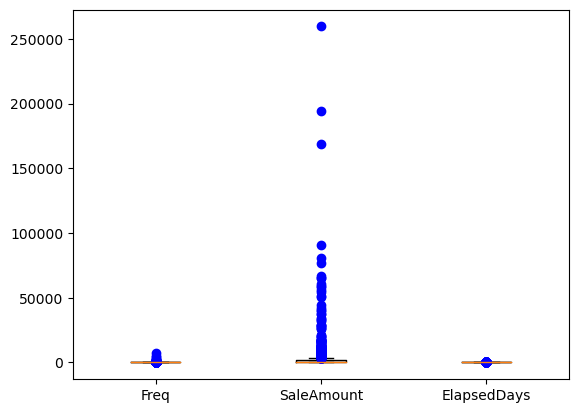

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
ax.boxplot([customer_df['Freq'], customer_df['SaleAmount'], customer_df['ElapsedDays']], sym='bo')
plt.xticks([1, 2, 3], ['Freq', 'SaleAmount','ElapsedDays' ])

plt.show()

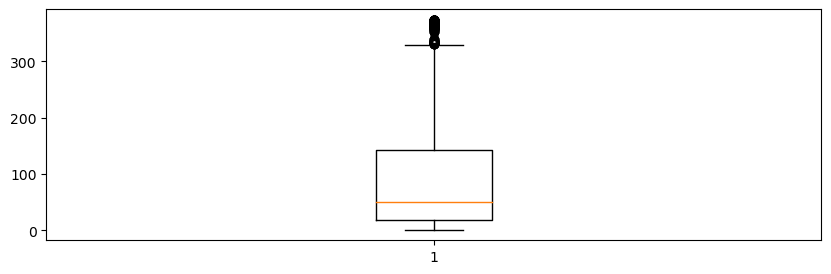

In [157]:
plt.figure(figsize=(10,3))
plt.boxplot(customer_df['ElapsedDays']);

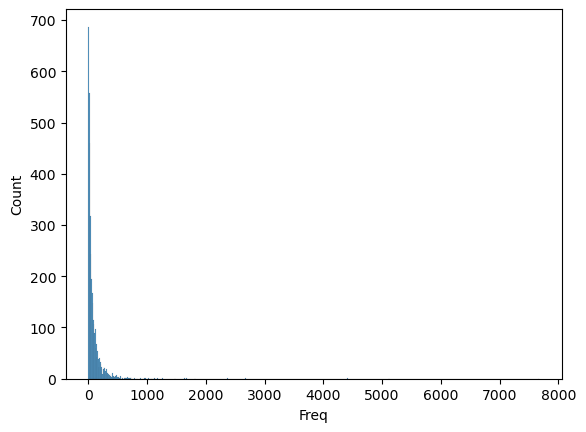

In [158]:
sns.histplot(customer_df.Freq);

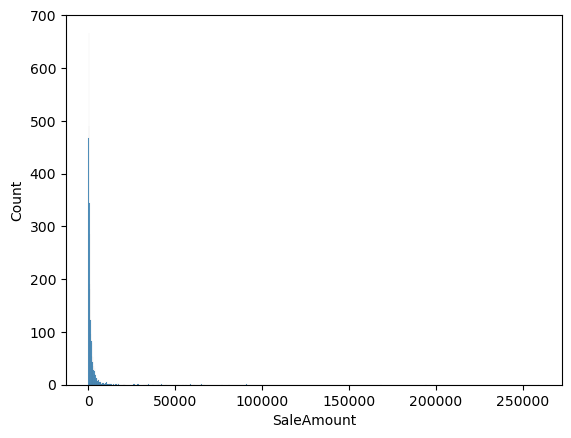

In [159]:
sns.histplot(customer_df.SaleAmount);

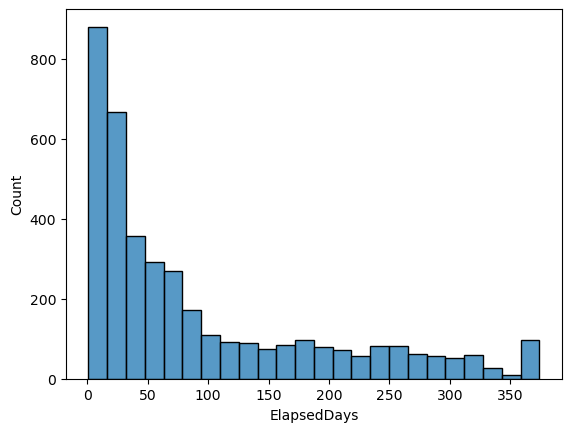

In [160]:
sns.histplot(customer_df.ElapsedDays);

#### - 데이터 값의 왜곡(치우침)을 줄이기 위한 작업 : 로그 함수로 분포 조정

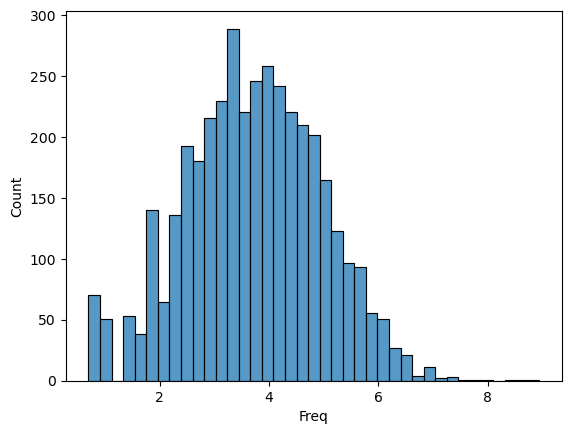

In [161]:
sns.histplot(np.log1p(customer_df['Freq']));

In [162]:
import numpy as np

customer_df['Freq_log'] = np.log1p(customer_df['Freq'])
customer_df['SaleAmount_log'] = np.log1p(customer_df['SaleAmount'])
customer_df['ElapsedDays_log'] = np.log1p(customer_df['ElapsedDays'])

customer_df.head()  #작업 확인용 출력

,CustomerID,SaleAmount,Freq,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log
0,12346,77183.60,1,326,0.693147,11.253955,5.789960
1,12747,4196.01,103,3,4.644391,8.342128,1.386294
2,12748,33053.19,4412,1,8.392310,10.405904,0.693147
3,12749,4090.88,199,4,5.298317,8.316760,1.609438
4,12820,942.34,59,4,4.094345,6.849427,1.609438


([<matplotlib.axis.XTick at 0x1634c6670>,
 [Text(1, 0, 'Freq_log'),
  Text(2, 0, 'SaleAmount_log'),
  Text(3, 0, 'ElapsedDays_log')])

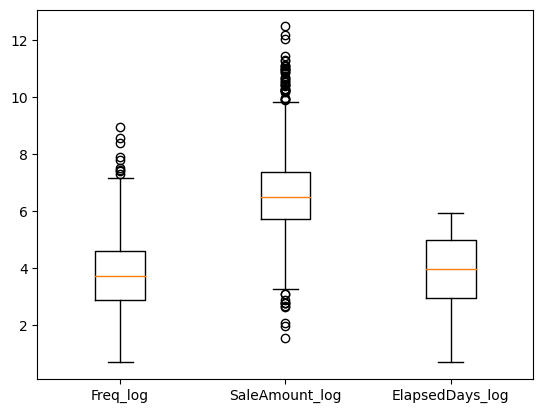

In [163]:
# 조정된 데이터 분포를 다시 박스플롯으로 확인하기
fig, ax = plt.subplots()
ax.boxplot([customer_df.Freq_log, customer_df.SaleAmount_log, \
                                      customer_df.ElapsedDays_log])
plt.xticks([1,2,3], ['Freq_log', 'SaleAmount_log', 'ElapsedDays_log'])

### 3) 모델 구축 : K-평균 군집화 모델 

In [164]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

X = customer_df[['Freq_log', 'SaleAmount_log', 'ElapsedDays_log']].values

In [165]:
# 정규분포를 전체 데이터 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-2.4075565 ,  3.78807665,  1.48161832],
       [ 0.74303024,  1.44784065, -1.88997639],
       [ 3.73149288,  3.10649751, -2.42067319],
       ...,
       [-0.9150454 , -1.08740107, -1.26910093],
       [ 2.28803357,  0.87060182, -1.71913018],
       [ 0.43866691,  0.78435249, -0.05406709]])

### - 최적의 k 찾기 (1) 엘보우 방법

In [166]:
# 클러스터 갯수를 1부터 10까지 변화시키면서 왜곡의 크기 변화를 그래프로 시각화
# 3, 4, 5중 하나
k_list = range(2,11)
inertias = []

for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(kmeans.inertia_)

6102.908983314023
4723.509638611359
3886.7348304296
3328.2100602281557
2942.8164266226786
2677.8677853312392
2477.501148600507
2309.18351817428
2165.0216519806118


In [167]:
inertias

[6102.908983314023,
 4723.509638611359,
 3886.7348304296,
 3328.2100602281557,
 2942.8164266226786,
 2677.8677853312392,
 2477.501148600507,
 2309.18351817428,
 2165.0216519806118]

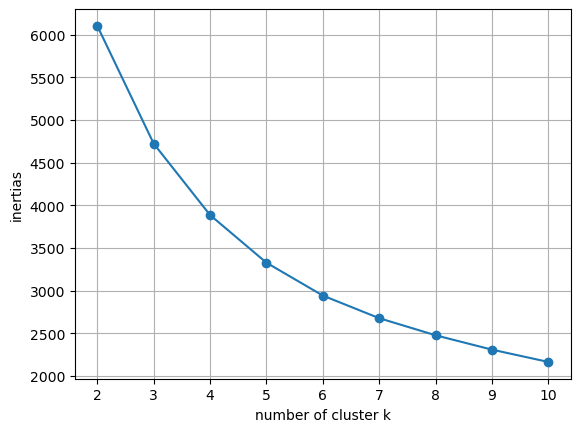

In [168]:
plt.plot(k_list, inertias, marker='o')
plt.xlabel('number of cluster k')
plt.ylabel('inertias')
plt.grid()
plt.show()

In [169]:
#모델 생성
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X=X_scaled)

# 모델 학습과 결과 예측(클러스터 레이블 생성)
len(kmeans.labels_)

pred = kmeans.predict(X_scaled)
pred

array([0, 2, 2, ..., 0, 2, 0], dtype=int32)

In [170]:
# 클러스터 번호를 정하는 원칙: 없음(크기 X, 위치X , random)
customer_df['Cluster'] = kmeans.labels_
customer_df

,CustomerID,SaleAmount,Freq,ElapsedDays,Freq_log,SaleAmount_log,ElapsedDays_log,Cluster
0,12346,77183.60,1,326,0.693147,11.253955,5.789960,0
1,12747,4196.01,103,3,4.644391,8.342128,1.386294,2
2,12748,33053.19,4412,1,8.392310,10.405904,0.693147,2
3,12749,4090.88,199,4,5.298317,8.316760,1.609438,2
4,12820,942.34,59,4,4.094345,6.849427,1.609438,2
...,...,...,...,...,...,...,...,...
3915,18280,180.60,10,278,2.397895,5.201806,5.631212,1
3916,18281,80.82,7,181,2.079442,4.404522,5.204007,1
3917,18282,178.05,12,8,2.564949,5.187665,2.197225,0
3918,18283,2045.53,721,4,6.582025,7.623901,1.609438,2


## 4) 결과 분석 및 시각화

### - 최적의 k (best_cluster) 찾기 (2) 실루엣 계수에 따른 각 클러스터의 비중 시각화 함수 정의

In [171]:
from matplotlib import cm

def silhouetteViz(n_cluster, X_features): 
    
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)
    
    silhouette_values = silhouette_samples(X_features, Y_labels, metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    y_ticks = []

    for c in range(n_cluster):
        c_silhouettes = silhouette_values[Y_labels == c]
        c_silhouettes.sort()
        y_ax_upper += len(c_silhouettes)
        color = cm.jet(float(c) / n_cluster)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouettes,
                 height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouettes)
    
    silhouette_avg = np.mean(silhouette_values)
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.title('Number of Cluster : '+ str(n_cluster)+'\n' \
              + 'Silhouette Score : '+ str(round(silhouette_avg,3)))
    plt.yticks(y_ticks, range(n_cluster))   
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()

### - 클러스터 수에 따른 클러스터 데이터 분포의 시각화 함수 정의

In [172]:
def clusterScatter(n_cluster, X_features): 
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)

    for i in range(n_cluster):
        c_color = cm.jet(float(i) / n_cluster) #클러스터의 색상 설정
        c_colors.append(c_color)
        #클러스터의 데이터 분포를 동그라미로 시각화
        plt.scatter(X_features[Y_labels == i,0], X_features[Y_labels == i,1],
                     marker='o', color=c_color, edgecolor='black', s=50, 
                     label='cluster '+ str(i))       
    
    #각 클러스터의 중심점을 삼각형으로 표시
    for i in range(n_cluster):
        plt.scatter(kmeans.cluster_centers_[i,0], kmeans.cluster_centers_[i,1], 
                    marker='^', color=c_colors[i], edgecolor='w', s=200)
        
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

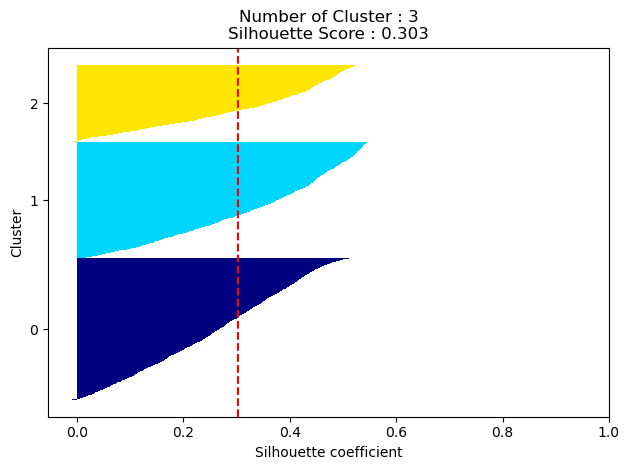

In [173]:
silhouetteViz(3, X_scaled) #클러스터 3개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

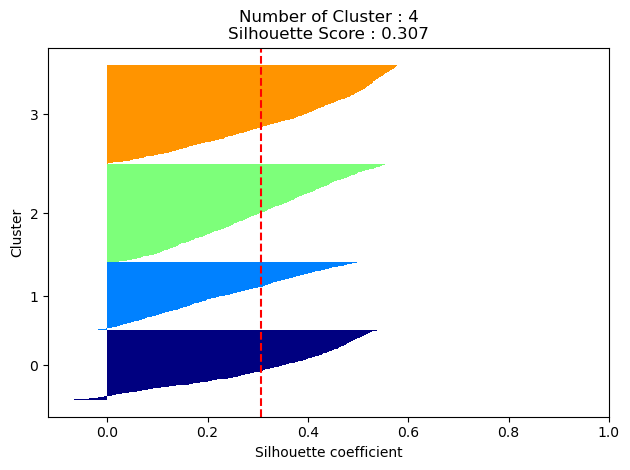

In [174]:
silhouetteViz(4, X_scaled) #클러스터 4개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

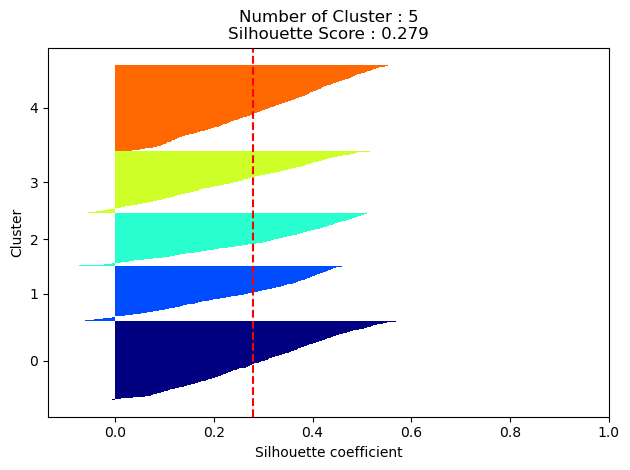

In [175]:
silhouetteViz(5, X_scaled) #클러스터 5개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

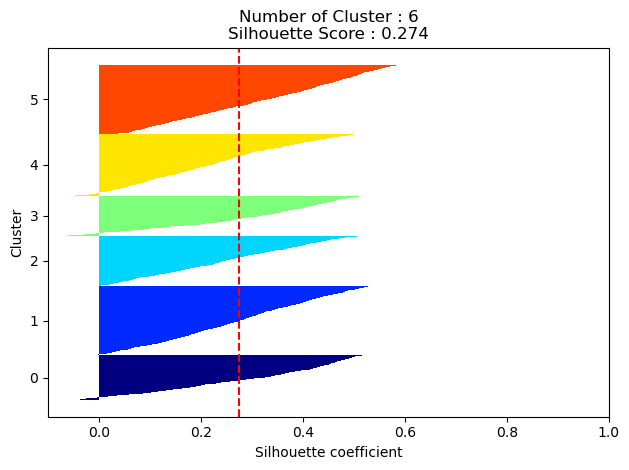

In [176]:
silhouetteViz(6, X_scaled) #클러스터 6개인 경우의 실루엣 score 및 각 클러스터 비중 시각화

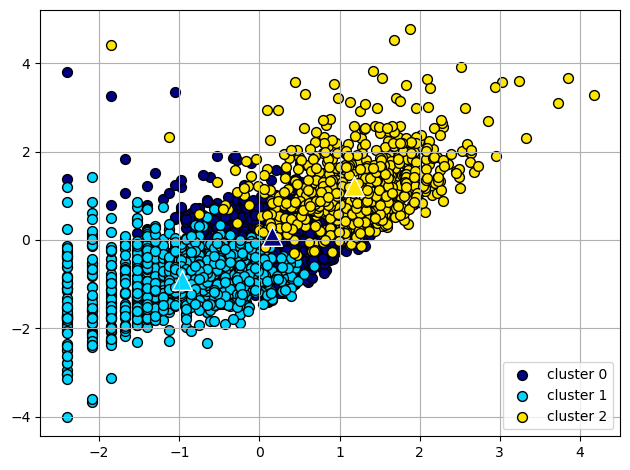

In [177]:
clusterScatter(3, X_scaled) #클러스터 3개인 경우의 클러스터 데이터 분포 시각화

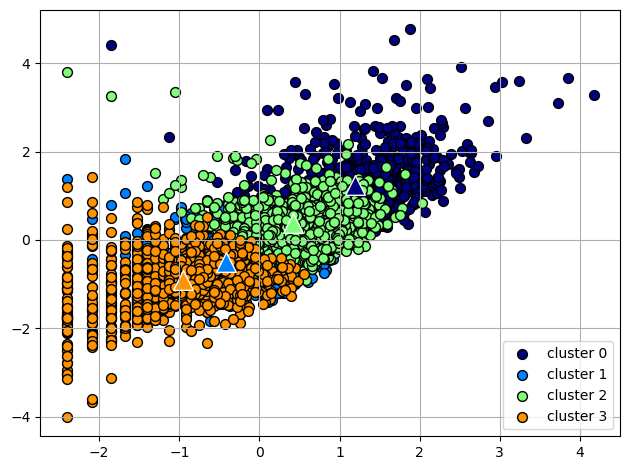

In [178]:
clusterScatter(4, X_scaled)  #클러스터 4개인 경우의 클러스터 데이터 분포 시각화

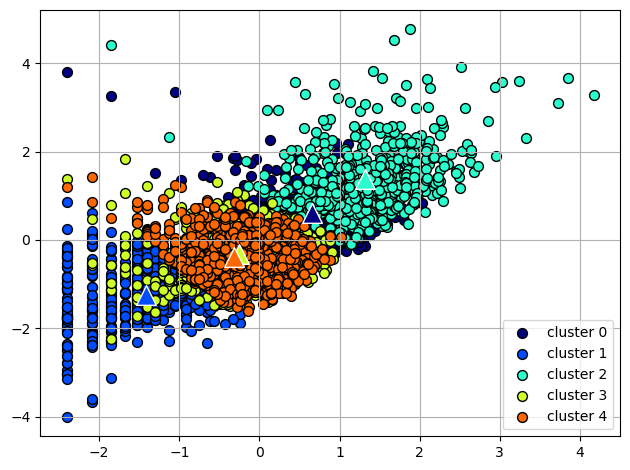

In [179]:
clusterScatter(5, X_scaled)  #클러스터 5개인 경우의 클러스터 데이터 분포 시각화

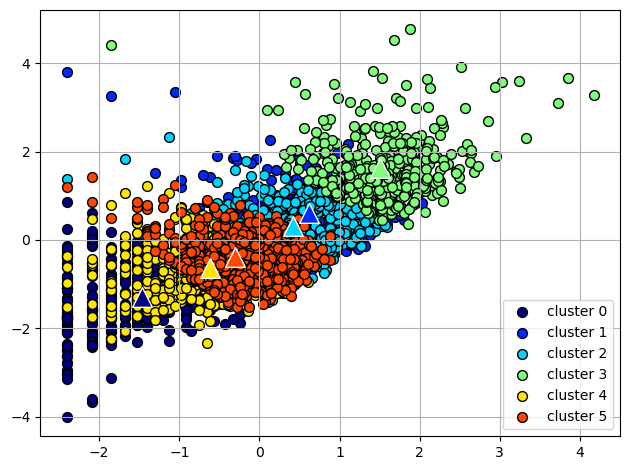

In [180]:
clusterScatter(6, X_scaled)  #클러스터 6개인 경우의 클러스터 데이터 분포 시각화

### 결정된 k를 적용하여 최적의 K-mans 모델 완성

In [181]:
customer_df = customer_df.drop(['Freq_log', 'SaleAmount_log', 'ElapsedDays_log'], \
                               axis=1)
customer_df

,CustomerID,SaleAmount,Freq,ElapsedDays,Cluster
0,12346,77183.60,1,326,0
1,12747,4196.01,103,3,2
2,12748,33053.19,4412,1,2
3,12749,4090.88,199,4,2
4,12820,942.34,59,4,2
...,...,...,...,...,...
3915,18280,180.60,10,278,1
3916,18281,80.82,7,181,1
3917,18282,178.05,12,8,0
3918,18283,2045.53,721,4,2


#### - ClusterLabel이 추가된 데이터를 파일로 저장

In [ ]:
customer_df.to_csv('./data/Online_Retail_Customer_Cluster4.csv')

## << 클러스터 분석하기 >>

### 1) 각 클러스터의 고객수 

In [182]:
customer_df.groupby('Cluster')['CustomerID'].mean()

Cluster
0    15560.038089
1    15600.657625
2    15507.399113
Name: CustomerID, dtype: float64

### 2) 각 클러스터의 특징

In [183]:
# 고객별 주문 1회당 평균 구매금액 : SaleAmountAvg
customer_df['SaleAmountAvg'] = customer_df.SaleAmount / customer_df.Freq
customer_df

,CustomerID,SaleAmount,Freq,ElapsedDays,Cluster,SaleAmountAvg
0,12346,77183.60,1,326,0,77183.600000
1,12747,4196.01,103,3,2,40.737961
2,12748,33053.19,4412,1,2,7.491657
3,12749,4090.88,199,4,2,20.557186
4,12820,942.34,59,4,2,15.971864
...,...,...,...,...,...,...
3915,18280,180.60,10,278,1,18.060000
3916,18281,80.82,7,181,1,11.545714
3917,18282,178.05,12,8,0,14.837500
3918,18283,2045.53,721,4,2,2.837074


In [129]:
# 클러스터별 분석
customer_df.groupby('Cluster')['SaleAmountAvg'].mean()

Cluster
0    84.379612
1    42.556845
2    92.919765
Name: SaleAmountAvg, dtype: float64